In [1]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

     |████████████████████████████████| 283 kB 32.7 MB/s 
     |████████████████████████████████| 321 kB 41.6 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85445 sha256=c47050c56886ec69cf5aa550bb4d1b01c077843570b1ec8249cfb1f15eac395a
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("nlp_train.csv")
df.head()

,id,keyword,location,text,target
0,1707,bridge%20collapse,NaN,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0
1,5789,hail,"Carol Stream, Illinois",GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @...,1
2,7789,police,Houston,CNN: Tennessee movie theater shooting suspect ...,1
3,8257,rioting,NaN,Still rioting in a couple of hours left until ...,1
4,10656,wounds,Lake Highlands,Crack in the path where I wiped out this morni...,0


In [3]:
dataset = pd.DataFrame({'Text':df['text'],'Target':df['target']})
dataset.head()

,Text,Target
0,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0
1,GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @...,1
2,CNN: Tennessee movie theater shooting suspect ...,1
3,Still rioting in a couple of hours left until ...,1
4,Crack in the path where I wiped out this morni...,0


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5329 entries, 0 to 5328
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    5329 non-null   object
 1   Target  5329 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 83.4+ KB


In [5]:
# build train and test datasets
text = dataset['Text'].values
labels = dataset['Target'].values

train_text = text[:3500]
train_labels = labels[:3500]

test_text = text[3500:]
test_labels = labels[3500:]

In [6]:

import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [7]:

%%time

norm_train_reviews = pre_process_corpus(train_text)
norm_test_reviews = pre_process_corpus(test_text)

100%|██████████| 1829/1829 [00:00<00:00, 7226.78it/s]

CPU times: user 742 ms, sys: 62.5 ms, total: 805 ms
Wall time: 811 ms


In [8]:
import tensorflow as tf

t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [9]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('httptcog5zsru0zvq', 13043), ('<PAD>', 0), 1)

In [10]:
train_sequences = t.texts_to_sequences(norm_train_reviews)
test_sequences = t.texts_to_sequences(norm_test_reviews)


In [11]:

print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=13044
Number of Documents=3500


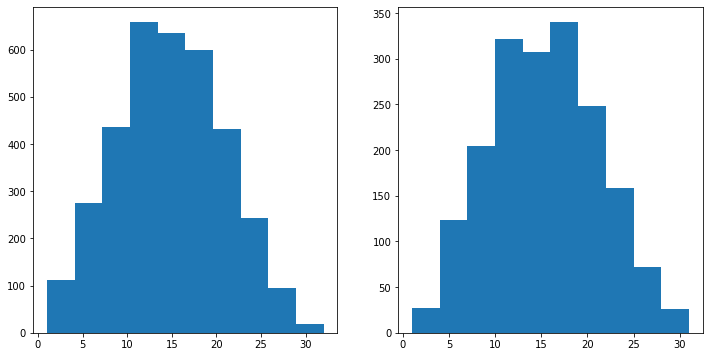

In [12]:

import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

SEQUENCE NORMALIZATION

In [13]:

MAX_SEQUENCE_LENGTH = 40

In [14]:

# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((3500, 40), (1829, 40))

In [15]:
VOCAB_SIZE = len(t.word_index)

In [16]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
LSTM_DIM = 128 # total LSTM units

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.SpatialDropout1D(0.1))
model.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           3913200   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 40, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 4,166,129
Trainable params: 4,166,129
Non-trainable params: 0
_________________________________________________________________


In [17]:
%%time
batch_size = 128
EPOCHS = 10

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(X_train, train_labels, epochs=EPOCHS, batch_size=batch_size, 
          callbacks=[es],
          shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
25/25 [==============================] - 9s 260ms/step - loss: 0.6555 - accuracy: 0.6048 - val_loss: 0.5890 - val_accuracy: 0.7229
Epoch 2/10
25/25 [==============================] - 6s 236ms/step - loss: 0.3554 - accuracy: 0.8552 - val_loss: 0.5071 - val_accuracy: 0.7686
Epoch 3/10
25/25 [==============================] - 6s 237ms/step - loss: 0.1235 - accuracy: 0.9552 - val_loss: 0.6492 - val_accuracy: 0.7800
Epoch 4/10
25/25 [==============================] - 6s 236ms/step - loss: 0.0491 - accuracy: 0.9851 - val_loss: 0.8693 - val_accuracy: 0.7457
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
CPU times: user 42.9 s, sys: 2.25 s, total: 45.2 s
Wall time: 26.9 s


In [18]:
# Final evaluation of the model
%%time
scores = model.evaluate(X_test, test_labels, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

58/58 [==============================] - 1s 25ms/step - loss: 0.5003 - accuracy: 0.7649
Accuracy: 76.49%
CPU times: user 2.31 s, sys: 150 ms, total: 2.46 s
Wall time: 17.8 s


In [19]:
predictions = model.predict_classes(X_test).ravel()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [20]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_labels, predictions))
pd.DataFrame(confusion_matrix(test_labels, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.76      0.84      0.80      1023
           1       0.77      0.67      0.71       806

    accuracy                           0.76      1829
   macro avg       0.77      0.75      0.76      1829
weighted avg       0.77      0.76      0.76      1829



,negative,positive
negative,862,161
positive,269,537


STACKED LSTM

In [21]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model2.add(tf.keras.layers.SpatialDropout1D(0.1))
model2.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=True))
model2.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))
model2.add(tf.keras.layers.Dense(256, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model2.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 300)           3913200   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 40, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 128)           219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 4,297,713
Trainable params: 4,297,713
Non-trainable params: 0
____________________________________________

In [22]:
%%time
batch_size = 128
EPOCHS = 10

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model2.fit(X_train, train_labels, epochs=EPOCHS, batch_size=batch_size, 
           callbacks=[es],
           shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
25/25 [==============================] - 14s 416ms/step - loss: 0.6396 - accuracy: 0.6222 - val_loss: 0.5661 - val_accuracy: 0.7200
Epoch 2/10
25/25 [==============================] - 9s 377ms/step - loss: 0.3399 - accuracy: 0.8584 - val_loss: 0.4816 - val_accuracy: 0.7943
Epoch 3/10
25/25 [==============================] - 9s 375ms/step - loss: 0.1523 - accuracy: 0.9413 - val_loss: 0.5863 - val_accuracy: 0.7686
Epoch 4/10
25/25 [==============================] - 10s 382ms/step - loss: 0.0666 - accuracy: 0.9775 - val_loss: 0.8984 - val_accuracy: 0.7314
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
CPU times: user 1min 8s, sys: 3.85 s, total: 1min 12s
Wall time: 42.2 s


In [23]:
# Final evaluation of the model
%%time
scores = model2.evaluate(X_test, test_labels, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

58/58 [==============================] - 2s 40ms/step - loss: 0.5085 - accuracy: 0.7704
Accuracy: 77.04%
CPU times: user 3.51 s, sys: 221 ms, total: 3.73 s
Wall time: 4.22 s


In [24]:
predictions = model2.predict_classes(X_test).ravel()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [25]:
labels = ['negative', 'positive']
print(classification_report(test_labels, predictions))
pd.DataFrame(confusion_matrix(test_labels, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      1023
           1       0.81      0.63      0.71       806

    accuracy                           0.77      1829
   macro avg       0.78      0.76      0.76      1829
weighted avg       0.78      0.77      0.77      1829



,negative,positive
negative,901,122
positive,298,508
